**Here we introduce a nuisance factor (median filtering) to see how much masking out the detailed texture affect the performance.**

In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook
from fastai.vision.learner import model_meta
import sys
from sklearn.metrics import roc_auc_score
import cv2
import albumentations
from fastai.torch_core import flatten_model
from fastai.layers import CrossEntropyFlat
from torchvision.models import *
from fastai import *
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
import pretrainedmodels

A prerained model will be a good starting point for a baseline model. Lets see a list of the PyTorch models that we could use.

In [3]:
# torchvision models
[k for k,v in sys.modules['torchvision.models'].__dict__.items() if callable(v)]

['alexnet',
 'AlexNet',
 'ResNet',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'resnext50_32x4d',
 'resnext101_32x8d',
 'VGG',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'SqueezeNet',
 'squeezenet1_0',
 'squeezenet1_1',
 'Inception3',
 'inception_v3',
 'DenseNet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'googlenet',
 'GoogLeNet',
 'MobileNetV2',
 'mobilenet_v2',
 'ShuffleNetV2',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0']

A pip package called pretrainedmodels has [Cadene pretrained model](https://github.com/Cadene/pretrained-models.pytorch).

This can be installed via ```pip install pretrainedmodels```.

In [4]:
# cadene models
pretrainedmodels.model_names

['fbresnet152',
 'bninception',
 'resnext101_32x4d',
 'resnext101_64x4d',
 'inceptionv4',
 'inceptionresnetv2',
 'alexnet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'inceptionv3',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'nasnetamobile',
 'nasnetalarge',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn131',
 'dpn107',
 'xception',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'cafferesnet101',
 'pnasnet5large',
 'polynet']

Utility functinos to get architecture descriptions from PyTorch models

In [5]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []
        
class FakeData:
    def __init__(self):
        self.c = 2
        self.path = ''    
        self.device = None
        self.loss_func = CrossEntropyFlat(axis=1)

In [6]:
# we wrap cadene model to pytorch models format
def resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['se_resnext50_32x4d'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers)

Print the architecture of the pretrained model 

In [7]:
arch_summary(resnext50_32x4d)

(0) Sequential  : 4   layers (total: 4)
(1) Sequential  : 38  layers (total: 42)
(2) Sequential  : 50  layers (total: 92)
(3) Sequential  : 74  layers (total: 166)
(4) Sequential  : 38  layers (total: 204)
(5) AvgPool2d   : 1   layers (total: 205)
(6) Linear      : 1   layers (total: 206)


Training parameters

In [8]:
BATCH_SIZE = 128
sz = 256
NUM_WORKERS = 32
model_name = '20190625-notexture-0-se_resnext50'

Use data augmentations that mimic the hue and color saturation variance caused by the different scanning isntruments and staining procedures. 

In [42]:
albumentations_transform = albumentations.Compose([
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
        albumentations.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.05)
    ],p=0.8),
    #albumentations.GaussNoise(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RandomGamma(gamma_limit=(80, 120), always_apply=False, p=0.05),
    #albumentations.imgaug.transforms.IAASuperpixels(p_replace=1, n_segments=1000, always_apply=True, p=1),
    albumentations.augmentations.transforms.MedianBlur(blur_limit=7, always_apply=True, p=1),
    albumentations.augmentations.transforms.MedianBlur(blur_limit=7, always_apply=True, p=1),
    albumentations.augmentations.transforms.MedianBlur(blur_limit=7, always_apply=True, p=1),
    albumentations.augmentations.transforms.MedianBlur(blur_limit=7, always_apply=True, p=1)
])

Validation augmentation may be less intensive.

In [43]:
albumentations_transform_validation = albumentations.Compose([
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    albumentations.HueSaturationValue(p=0.1)
])

### Show training augmentations

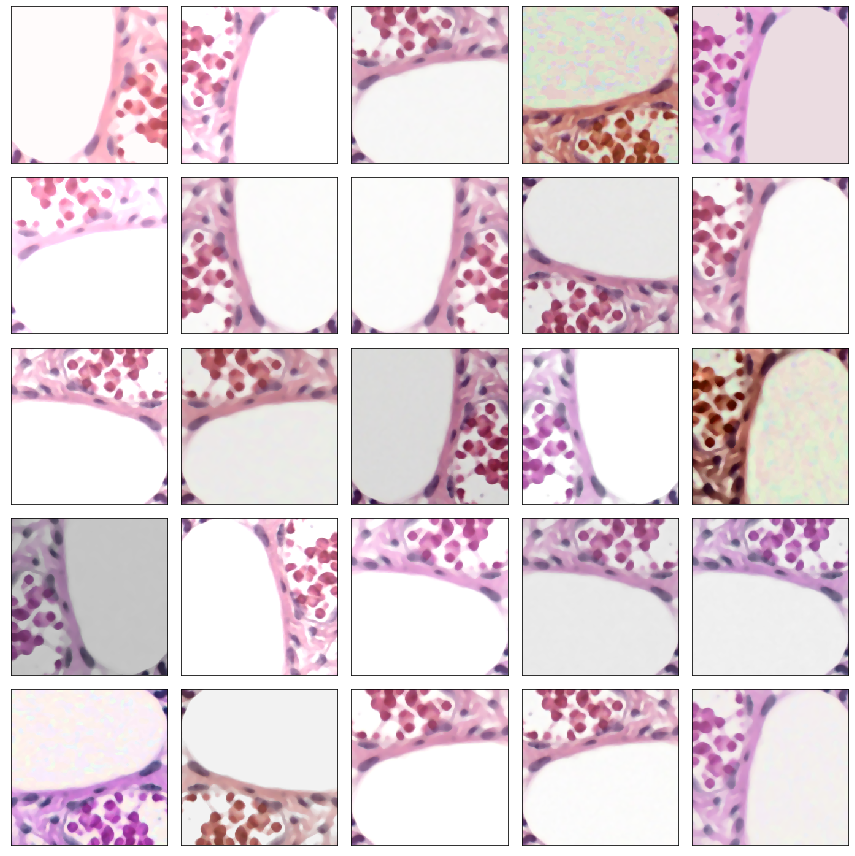

In [44]:
# sample image
img = cv2.imread('data/patches/1066240043904_0.png')

fig, ax = plt.subplots(5,5, figsize=(12,12))
for i in range(5):
    for j in range(5):
        augmented = albumentations_transform(image=img)
        ax[i,j].imshow(augmented['image'])
        ax[j, i].xaxis.set_major_locator(plt.NullLocator())
        ax[j, i].yaxis.set_major_locator(plt.NullLocator())
plt.tight_layout()

### Show validation augmentations

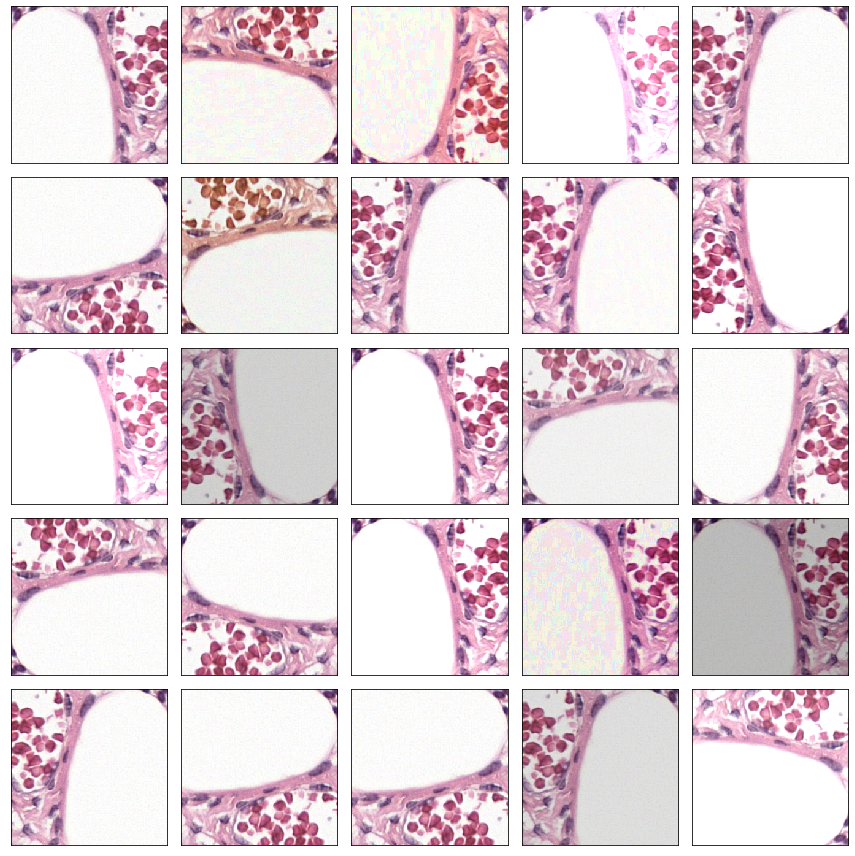

In [45]:
fig, ax = plt.subplots(5,5, figsize=(12,12))
for i in range(5):
    for j in range(5):
        augmented = albumentations_transform_validation(image=img)
        ax[i,j].imshow(augmented['image'])
        ax[j, i].xaxis.set_major_locator(plt.NullLocator())
        ax[j, i].yaxis.set_major_locator(plt.NullLocator())
plt.tight_layout()

Custom image lists

In [46]:
# Subclass ImageItemList to use our own image opening function
class MyImageItemList(ImageList):
    def open(self, fn:PathOrStr)->Image:
        img = cv2.imread(fn)
        # Apply transformations
        augmented = albumentations_transform(image=img)
        # Convert numpy array to tensor
        return vision.Image(px=pil2tensor(augmented['image']/255., np.float32))

class MyImageItemListValid(ImageList):
    def open(self, fn:PathOrStr)->Image:
        img = cv2.imread(file_path)
        # Apply transformations
        augmented = albumentations_transform_validation(image=img)
        # Convert numpy array to tensor
        return vision.Image(px=pil2tensor(augmented['image']/255., np.float32))

Load dataframes

In [47]:
df = pd.read_csv('data/training/training.csv').set_index('Unnamed: 0')
df['is_valid'] = False
df_valid = pd.read_csv('data/training/validation_1.csv').set_index('Unnamed: 0')
df_valid['is_valid'] = True
df = pd.concat([df,df_valid],ignore_index=True)
len(df)

128668

- Use only 0-level images in this model.
- Normalize with Imagenet stats because the pretrained model has been trained with similar normalization.

In [48]:
# Create ImageDataBunch using fastai data block API
imgDataBunch = (MyImageItemList.from_df(path='data/patches/', df=df, suffix='_0.png')
    #Where to find the data?
    .split_from_df('is_valid')
    #How to split in train/valid? CV index
    .label_from_df(cols='tumorLabel')
    #Where are the labels?
    .transform(tfms=[[],[]], size=sz)
    # We have our custom transformations implemented in the image loader but we could apply transformations also here
    # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
    .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS)
    # convert to databunch
    .normalize(imagenet_stats))

**Plot samples from train and valid. sets for sanity check**

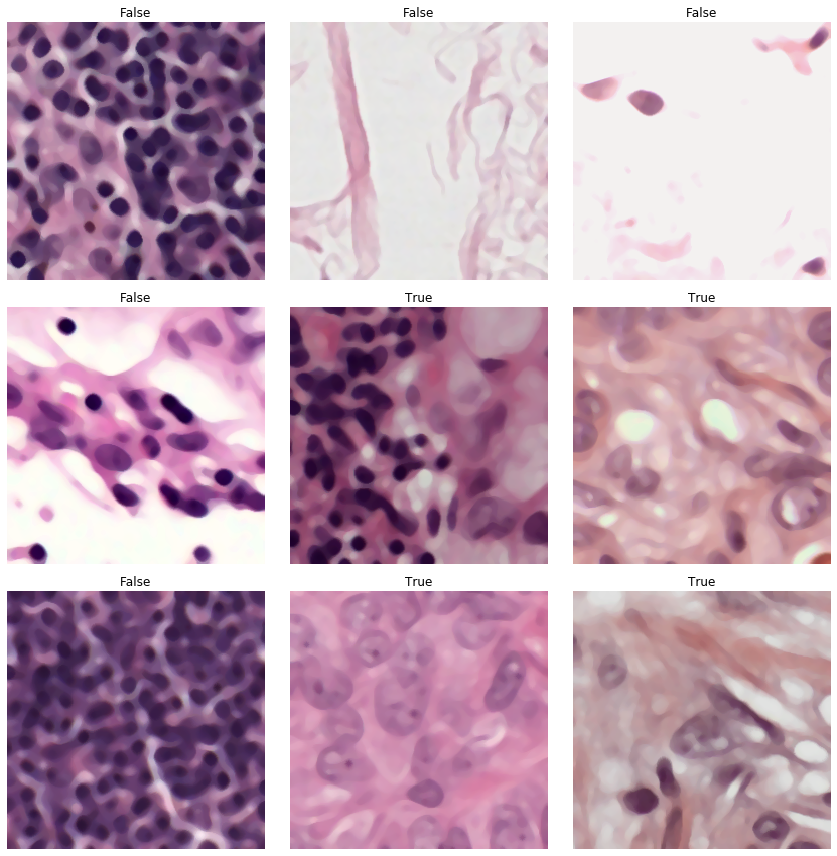

In [49]:
imgDataBunch.show_batch(rows=3, ds_type=DatasetType.Train)

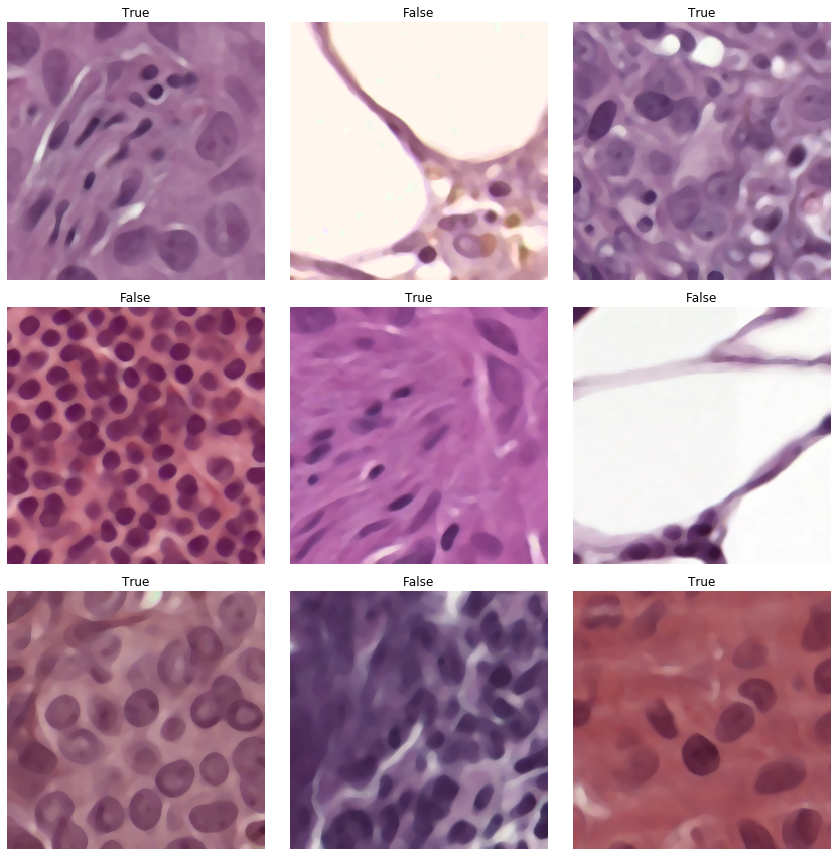

In [50]:
imgDataBunch.show_batch(rows=3, ds_type=DatasetType.Valid)

### Training

**Split from two parts:**

**SPLIT**
`layer group 0`

(0) Sequential  : 4   layers (total: 4)

(1) Sequential  : 38  layers (total: 42)

(2) Sequential  : 50  layers (total: 92)

(3) Sequential  : 74  layers (total: 166)

**SPLIT**
`layer group 1`

(4) Sequential  : 38  layers (total: 204)

(5) AvgPool2d   : 1   layers (total: 205)

**SPLIT**
`layer group 2`

(6) Linear      : 1   layers (total: 206)

In [51]:
learner = cnn_learner(imgDataBunch,
                      resnext50_32x4d,
                      pretrained=True,
                      #cut=-2, 
                      split_on=lambda m: (m[0][4], m[1]),
                      path='.',
                      metrics=[accuracy],
                      ps=0.9,
                      callback_fns=ShowGraph)

learner.crit=nn.BCEWithLogitsLoss()

In [52]:
# This group is not trained at all
learner.layer_groups[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace)
  (11): AdaptiveAvgPool2d(output_size=1)
  (12): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  (15): S

In [53]:
# This is the middle trainable part
learner.layer_groups[1]

Sequential(
  (0): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32, bias=False)
  (3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (5): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace)
  (7): AdaptiveAvgPool2d(output_size=1)
  (8): Conv2d(2048, 128, kernel_size=(1, 1), stride=(1, 1))
  (9): ReLU(inplace)
  (10): Conv2d(128, 2048, kernel_size=(1, 1), stride=(1, 1))
  (11): Sigmoid()
  (12): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (13): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Conv2d(2048, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (15): BatchNor

In [54]:
# This is always trained
learner.layer_groups[2]

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): AdaptiveMaxPool2d(output_size=1)
  (2): Flatten()
  (3): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.45)
  (5): Linear(in_features=4096, out_features=512, bias=True)
  (6): ReLU(inplace)
  (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Dropout(p=0.9)
  (9): Linear(in_features=512, out_features=2, bias=True)
)

In [55]:
# freeze first two groups and train the head first
learner.freeze_to(2)

In [56]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


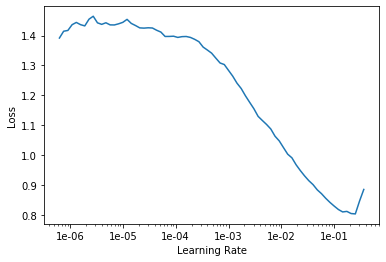

In [80]:
# and plot the losses of the first cycle
learner.recorder.plot()

Learning rate 1e-2 seems like a good initial learning rate. The LR test shows that it's still descending in that area.

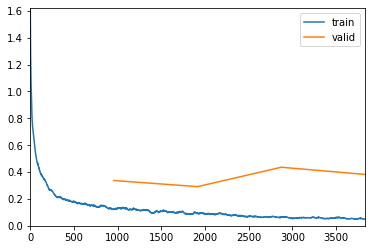

Better model found at epoch 0 with val_loss value: 0.33697712421417236.
Better model found at epoch 1 with val_loss value: 0.291415810585022.


In [57]:
learner.fit_one_cycle(4,
                      1e-2,
                     callbacks=[
                          SaveModelCallback(learner,
                                            every='improvement',
                                            monitor='val_loss',
                                            name= model_name + '_best_stage-1')
                      ])

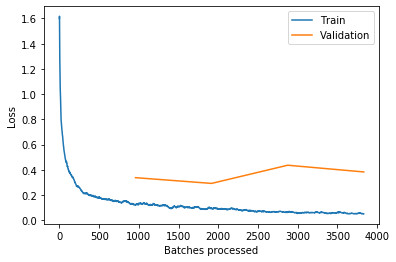

In [58]:
learner.recorder.plot_losses()

In [60]:
#learner.load(model_name + '_best_stage-1')

Unfreeze the middle layer group and continue training with smaller LR

In [59]:
# unfreeze last two groups
#learner.freeze_to(1)
#learner.lr_find()
#learner.recorder.plot()

In [61]:
#learner.fit_one_cycle(4,
#                      3e-5,
#                      callbacks=[
#                          SaveModelCallback(learner,
#                                            every='improvement',
#                                            monitor='val_loss',
#                                            name= model_name + '_best_stage-2')
#                      ])

In [62]:
#learner.recorder.plot_losses()

In [63]:
learner.load(model_name + '_best_stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (122626 items)
x: MyImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
True,True,False,True,False
Path: data/patches;

Valid: LabelList (6042 items)
x: MyImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
True,False,True,False,True
Path: data/patches;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128,

# Validation

In [64]:
preds,y, loss = learner.get_preds(with_loss=True, ds_type=DatasetType.Valid)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.893081784248352 %.


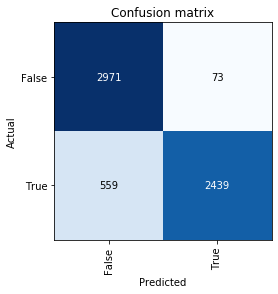

In [65]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [66]:
from random import randint

def plot_overview(interp:ClassificationInterpretation, classes=['Normal','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Predicted / Actual / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

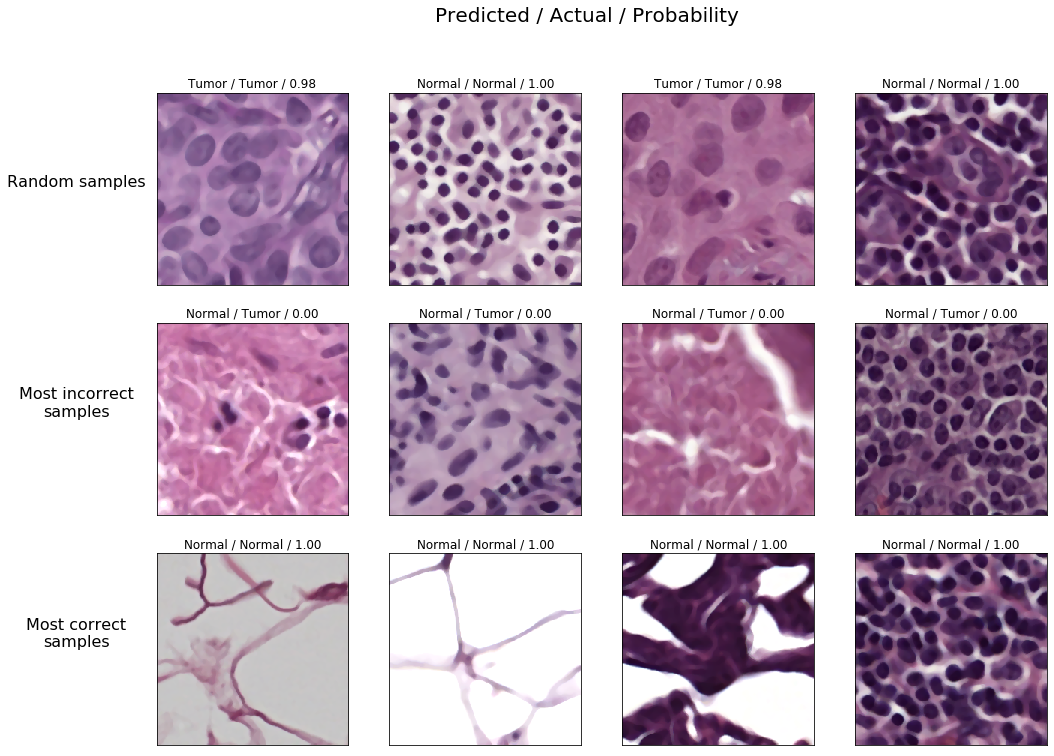

In [67]:
#interp = ClassificationInterpretation.from_learner(learner)
plot_overview(interp, ['Normal','Tumor'])

In [68]:
from fastai.callbacks.hooks import *

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [69]:
# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = imgDataBunch.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = imgDataBunch.one_item(tensorImg)
    oneBatch_im = vision.Image(imgDataBunch.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    
    # attach hooks
    #hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    hook_a_tumor,hook_g_tumor = hooked_backward(m, oneBatch, 1)
    # get convolutional activations and average from channels
    acts_tumor = hook_a_tumor.stored[0].cpu()

    # Grad-CAM
    grad_tumor = hook_g_tumor.stored[0][0].cpu()
    grad_chan_tumor = grad_tumor.mean(1).mean(1)
    mult_tumor = F.relu((acts_tumor*grad_chan_tumor[...,None,None]).mean(0))
    
    hook_a_normal,hook_g_normal = hooked_backward(m, oneBatch, 0)
    # get convolutional activations and average from channels
    acts_normal = hook_a_normal.stored[0].cpu()

    # Grad-CAM
    grad_normal = hook_g_normal.stored[0][0].cpu()
    grad_chan_normal = grad_normal.mean(1).mean(1)
    mult_normal = F.relu((acts_normal*grad_chan_normal[...,None,None]).mean(0))
    
    return mult_tumor, mult_normal, cvIm

In [70]:
# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    mask_alpha = 0.3
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM, Green=Normal, Red=Tumor\nPredicted / Actual / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act_tumor, act_normal, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act_tumor, alpha=mask_alpha, extent=(0,H,W,0),
              interpolation='bilinear', cmap='Reds')
        ax[0,i].imshow(act_normal, alpha=mask_alpha, extent=(0,H,W,0),
              interpolation='bilinear', cmap='Greens')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act_tumor, act_normal, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act_tumor, alpha=mask_alpha, extent=(0,H,W,0),
              interpolation='bilinear', cmap='Reds')
        ax[1,i].imshow(act_normal, alpha=mask_alpha, extent=(0,H,W,0),
              interpolation='bilinear', cmap='Greens')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act_tumor, act_normal, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act_tumor, alpha=mask_alpha, extent=(0,H,W,0),
              interpolation='bilinear', cmap='Reds')
        ax[2,i].imshow(act_normal, alpha=mask_alpha, extent=(0,H,W,0),
              interpolation='bilinear', cmap='Greens')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

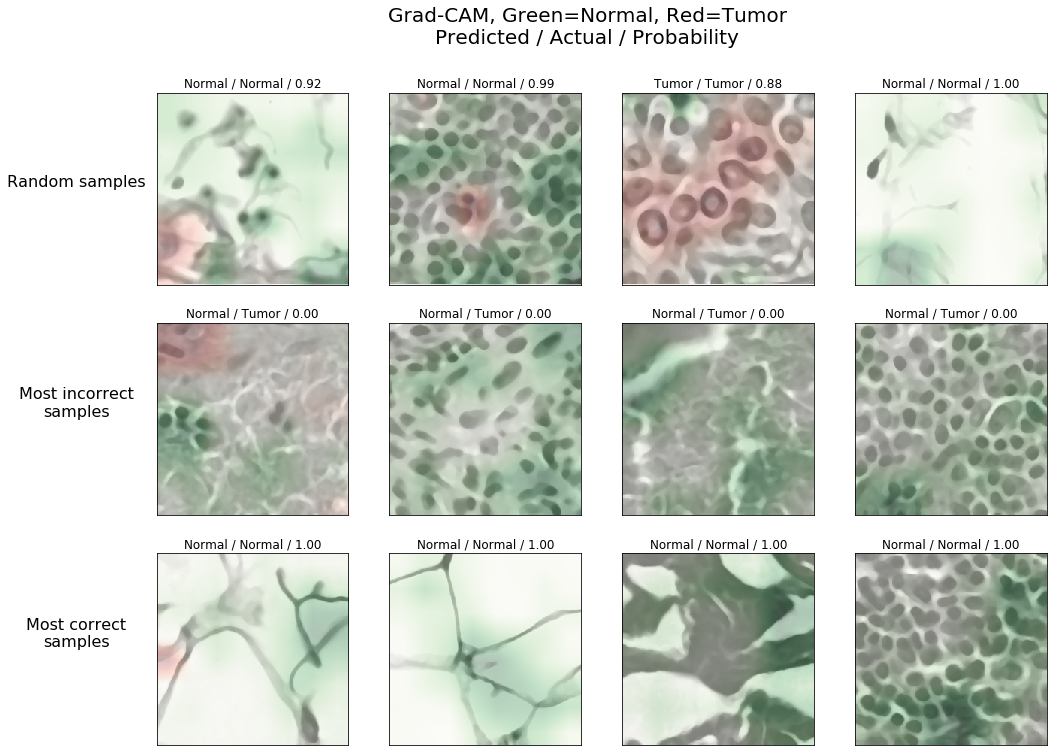

In [71]:
plot_heatmap_overview(interp, ['Normal','Tumor'])

## AUC

In [72]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9746573273991683


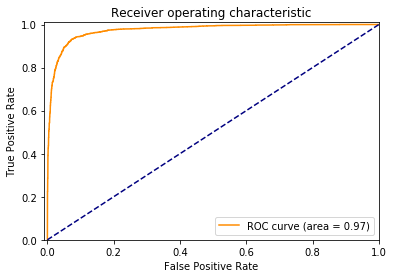

In [73]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")